<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 11

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* The flower to explain the Iris dataset comes from this [source](https://www.ritchieng.com/machine-learning-iris-dataset/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Continuation of tutorial on supervised learning (again, no theory today!)
    - Multidimensional regression with Gaussian Processes and Artificial Neural Networks
* Classification with supervised learning: quick tutorial using Decision Trees and Support Vector Machines

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is also going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects **without deriving the models yet**.

* We will continue to focus on regression via supervised learning with the same methods but now considering multiple dimensions:
    - **Gaussin Processes** using [scikit-learn](https://scikit-learn.org)
    - **Artificial Neural Networks** (ANNs) using [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/)
* We will also do a quick example on classification via supervised learning with:
    - **Decision trees** using [scikit-learn](https://scikit-learn.org)
    - **Support vector machines** using [scikit-learn](https://scikit-learn.org)

Remember: there are many (many!) more ML models out there. We are covering a few simple ones... The hope is that you feel comfortable with applying and deriving different models!

# 1. Multidimensional regression

Similarly to what we did for one-dimension, now we are going to show how to do multidimensional regression with supervised learning.

As you will see, it's pretty much the same thing...

* We will use less obvious functions to generate our datasets for subsequent learning.


* There is a nice website listing many different benchmark functions used in optimization: https://www.sfu.ca/~ssurjano/optimization.html

Let's try to learn some of them...

In [2]:
# Line below is to enable live rotation of the surface plots.
#%matplotlib notebook
#
from matplotlib import cm # to change colors of surface plots
#
# Let's define some functions that are often used to benchmark
# algorithms (especially in optimization)
def levy( x ):
    function_name = 'Levy' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        z = 1 + (x[ii,:] - 1) / 4
        y[ii] = (np.sin( np.pi * z[0] )**2
            + sum( (z[:-1] - 1)**2 * (1 + 10 * np.sin( np.pi * z[:-1] + 1 )**2 ))
            +       (z[-1] - 1)**2 * (1 + np.sin( 2 * np.pi * z[-1] )**2 ))
    return (np.atleast_1d(y), function_name)
#
# The next cell (hidden in presentation) includes a few more functions (so that you can play with this notebook).

In [3]:
def ackley( x, a=20, b=0.2, c=2*np.pi ):
    function_name = 'Ackley' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        s1 = sum( x[ii,:]**2 )
        s2 = sum( np.cos( c * x[ii,:] ))
        y[ii] = -a*np.exp( -b*np.sqrt( s1 / n_features )) - np.exp( s2 / n_features ) + a + np.exp(1)
    return (np.atleast_1d(y), function_name)
#
def rosenbrock( x ):  # rosen.m
    function_name = 'Rosenbrock' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        x0 = x[ii,:-1]
        x1 = x[ii,1:]
        y[ii] = (sum( (1 - x0) **2 )
            + 100 * sum( (x1 - x0**2) **2 ))
    return (np.atleast_1d(y), function_name)
#
def schwefel( x ):  # schw.m
    function_name = 'Schwefel' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 418.9829*n_features - sum( x[ii,:] * np.sin( np.sqrt( abs( x[ii,:] ))))
    return (np.atleast_1d(y), function_name)
#
def griewank( x, fr=4000 ):
    function_name = 'Griewank' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    j = np.arange( 1., n_features+1 )
    for ii in range(n_points):
        s = sum( x[ii,:]**2 )
        p = np.prod( np.cos( x[ii,:] / np.sqrt(j) ))
        y[ii] = s/fr - p + 1
    return (np.atleast_1d(y), function_name)
#
def rastrigin( x ):  # rast.m
    function_name = 'Rastrigin' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 10*n_features + sum( x[ii,:]**2 - 10 *
                                np.cos( 2 * np.pi * x[ii,:] ))
    return (np.atleast_1d(y), function_name)
#
# end of functions for benchmark.

#
seed = 1987 # set a random seed to replicate results
np.random.seed(seed)

Let's start by considering equally spaced sampling points, as we did in our previous lectures.

In [4]:
# Uniform grid of points for two-dimensional input
n_points_per_dimension = 50
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
# x3 = np.linspace(-10.0, 10.0, n_points_per_dimension) # if the input was 3D

X1_grid, X2_grid = np.meshgrid(x1, x2) # creates a grid of points that is necessary to plot surfaces
#X1_grid, X2_grid, X3_grid = np.meshgrid(x1, x2, x3) # e.g. for 3D input

print("Note that the X1_grid (and X2_grid) are 2D arrays with the following size:\n", np.shape(X1_grid))

Note that the X1_grid (and X2_grid) are 2D arrays with the following size:
 (50, 50)


In [5]:
# Uniform grid of points for two-dimensional input
n_points_per_dimension = 50
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
# x3 = np.linspace(-10.0, 10.0, n_points_per_dimension)

X1_grid, X2_grid = np.meshgrid(x1, x2)
#X1_grid, X2_grid, X3_grid = np.meshgrid(x1, x2, x3) # e.g. for 3D input

# Input points reshaped for Pandas dataframe
Data_X = np.array([X1_grid, X2_grid]).reshape(2, -1).T
#Data_X = np.array([X1_grid, X2_grid, X3_grid]).reshape(3, -1).T

# Output data created from one of the benchmark functions:
# levy, ackley, rosenbrock, schwefel, griewank, rastrigin
Data_y, function_name = schwefel(Data_X) # calculate the output vector Data_y (1D output) from input data (2D input)

print("The output of the function is a vector with size:\n", np.shape(Data_y))

# Reshape output data for use in Surface plot:
Y_grid = np.reshape(Data_y,np.shape(X1_grid))

print("So, we reshape the output vector into a 2D array needed to plot surfaces:\n", np.shape(Y_grid))

# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv

The output of the function is a vector with size:
 (2500, 1)
So, we reshape the output vector into a 2D array needed to plot surfaces:
 (50, 50)


Let's plot the function in a few different ways:
* Left subplot: 3D surface of the function
* Right subplot: a wireframe of the surface (no colors)

In [6]:
fig1 = plt.figure(figsize=plt.figaspect(0.5))

# Subplot 1 (left) of Figure 1
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
# Surface plot:
surf = ax1.plot_surface(X1_grid, X2_grid, Y_grid, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax1.set_xlabel('$x_1$', fontsize=20)
ax1.set_ylabel('$x_2$', fontsize=20)
ax1.set_zlabel('$f(x_1,x_2)$', fontsize=20)
ax1.set_title("%s function" % function_name, fontsize=20)

# Subplot 2 (right) of Figure 1
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
# Plot a 3D wireframe (no colors)
ax2.plot_wireframe(X1_grid, X2_grid, Y_grid, rstride=5, cstride=5)
ax2.set_xlabel('$x_1$', fontsize=20)
ax2.set_ylabel('$x_2$', fontsize=20)
ax2.set_zlabel('$f(x_1,x_2)$', fontsize=20)
ax2.set_title("%s function" % function_name, fontsize=20)
#plt.tight_layout() # if we want to enlarge the figures, but sometimes this leads to label occlusion.
plt.close(fig1)

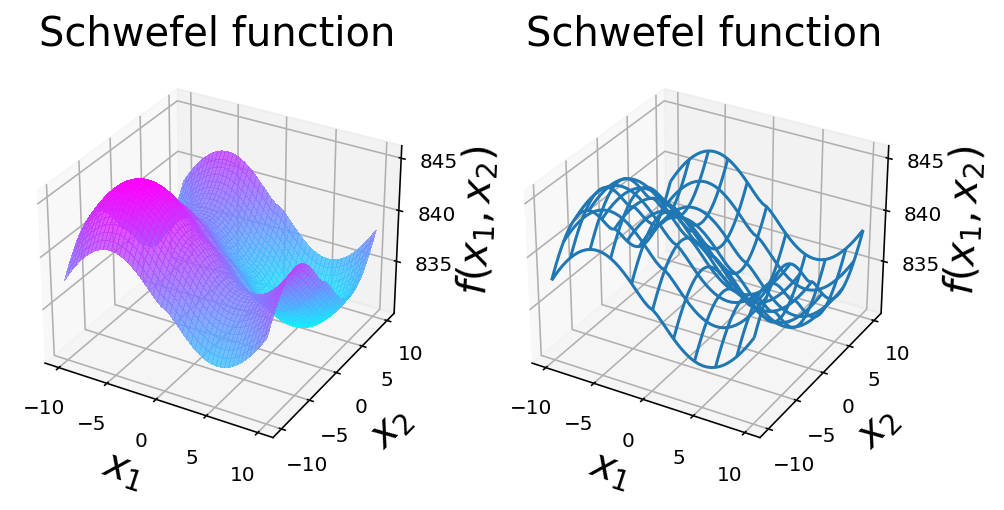

In [7]:
fig1

In the next figure, we show a contour plot of the same function.

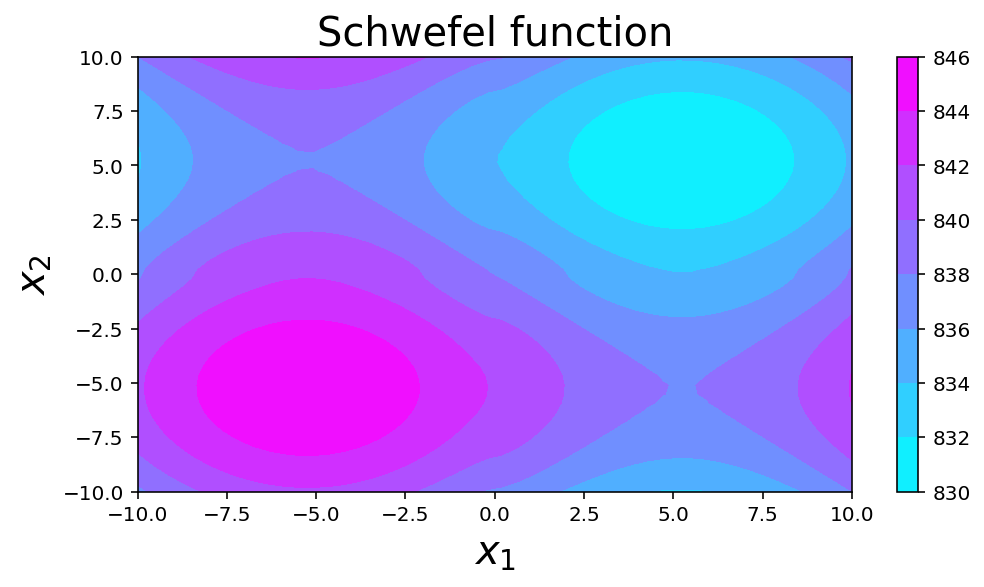

In [8]:
fig2, ax = plt.subplots()
cset = ax.contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_title("%s function" % function_name, fontsize=20)
fig2.colorbar(cset, ax=ax)

Let's create a pandas dataframe for the above dataset, i.e. for the inputs (features 'x1' and 'x2') and outputs (target 'y1').

In [9]:
import pandas as pd
input_dictionary = {
            'x1' : Data_X[:,0],
            'x2' : Data_X[:,1],
            #'x3' : Data_X[:,2],
            'y1' : Data_y[:,0]
            }
#
# Then, we create a Pandas data frame:
df = pd.DataFrame(input_dictionary)

print(df)

             x1    x2          y1
0    -10.000000 -10.0  837.552129
1     -9.591837 -10.0  838.185887
2     -9.183673 -10.0  838.777493
3     -8.775510 -10.0  839.323512
4     -8.367347 -10.0  839.820614
...         ...   ...         ...
2495   8.367347  10.0  836.110986
2496   8.775510  10.0  836.608088
2497   9.183673  10.0  837.154107
2498   9.591837  10.0  837.745713
2499  10.000000  10.0  838.379471

[2500 rows x 3 columns]


In Lecture 2 we already introduced pandas. Take a look at how to access the data in 3 different ways:

1. Direct way to select columns & rows by how they were labeled originaly


2. DataFrame.loc to select columns & rows by Name


3. DataFrame.iloc to select columns & rows by Index Positions (integer numbers)

In [10]:
# Let's access every row of feature 'x1' and of target 'y1':
way1 = df[['x1','y1']] # direct way

way2 = df.loc[:,['x1','y1']] # using the labels of rows and columns

way3 = df.iloc[:,[0,2]] # using indices (integers) of rows and columns

print('way 1 =\n', way1, '\n\n') # the '\n' is to make a new line for visualization purposes only.
print('way 2 =\n', way2, '\n\n')
print('way 3 =\n', way3, '\n\n')

way 1 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 2 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 3 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.

In [11]:
# Now let's access rows 2 until 5 (inclusive) of feature 'x2' an target 'y1':

# I think we can't do that by the direct way (correct me if I am wrong)
way2 = df.loc[2:5,['x2','y1']] # using the labels of data. Note that here when we write 2:5 (it includes)
                               # row with index 5

way3 = df.iloc[2:6,[1,2]] # using indices (integers) of the data note that we write 2:6 to include 5,
                          # which differs from way2 (!).
# way3 = df.iloc[2:6,1:3] # Alternative to accessing 'x2' and 'y1' by writing 1:3 instead of [1,2]

print('Specific rows, way 2 =\n', way2, '\n\n')
print('Specific rows, way 3 =\n', way3, '\n\n')

Specific rows, way 2 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 


Specific rows, way 3 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 




Now let's load our data into numpy variables from our Pandas DataFrame.

In [12]:
X_data = df.loc[:,['x1','x2']].values # note that we ask for the values, not a subset of the DataFrame
y_data = df.loc[:,'y1'].values

print(X_data)
print(y_data)

[[-10.         -10.        ]
 [ -9.59183673 -10.        ]
 [ -9.18367347 -10.        ]
 ...
 [  9.18367347  10.        ]
 [  9.59183673  10.        ]
 [ 10.          10.        ]]
[837.55212937 838.18588668 838.77749275 ... 837.15410725 837.74571332
 838.37947063]


<a id='#split_dataset'></a>

As usual, split the dataset into training and testing sets.

* For now, let's split the data with the following ratio: 2% for training set, and 98% for testing set

Note: the commonly used ratio is 75% for training and 25% for testing, but we will use Gaussian Processes and they can learn from very little data.

In [13]:
# Train/test split like we did before!
from sklearn.model_selection import train_test_split

testset_ratio = 0.98 # ratio of test set points from the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

As mentioned before, it is good practice to **scale the dataset** (e.g. in ANNs this is important).

Scikit-learn has implemented different [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) strategies. **Check the documentation**.

For example, two common strategies are:

1. StandardScaler: each feature is transformed to have zero-mean and unit standard deviation. In other words, the data becomes normally distributed, i.e. it becomes transformed. **Standardization of datasets is a common requirement for many machine learning estimators**.

2. MinMaxScaler: this transformation is simpler, as it just scales the data such that the maximum and minimum value are bounded to specified values (by default between 0 and 1). This keeps the distribution of the data (non distorting), i.e. it **does not** reduce the importance of outliers.

In [14]:
from sklearn.preprocessing import StandardScaler
# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler().fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)

from sklearn.preprocessing import MinMaxScaler
# Scaling outputs with a MinMax Scaler (just to show a different one!):
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)
#
scaler_y = MinMaxScaler(feature_range=(-1,1)).fit(y_train)
#
y_train_scaled=scaler_y.transform(y_train)
y_test_scaled=scaler_y.transform(y_test)
y_data_scaled=scaler_y.transform(y_data)

## 1.1. Multidimensional regression with Gaussian Processes

Let's create a Gaussian Process Regression model for this training data and fit it to the entire dataset as well as to the test data.

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train_scaled, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_pred, sigma_data_pred = gp_model.predict(X_data_scaled, return_std=True) # also output the uncertainty (standard deviation)

# Predict for test set (for error metric)
y_test_pred, sigma_test_pred = gp_model.predict(X_test_scaled, return_std=True) # also output the uncertainty (standard deviation)

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Now that we created the GPR model, let's create Surface plots to visualize the approximation when compared with the ground truth function.

In [16]:
fig1 = plt.figure(figsize=plt.figaspect(0.5))
# Subplot 1 (left): ground truth
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1_grid, X2_grid, Y_grid, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
# Create axis labels and title:
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x_1,x_2)$')
ax1.set_title("Ground truth of %s function" % function_name)

# Subplot 2 (right): GPR approximation
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
Y_grid_data_pred = np.reshape(y_data_pred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax2.plot_surface(X1_grid, X2_grid, Y_grid_data_pred, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
# Create axis labels and title:
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$f(x_1,x_2)$')
ax2.set_title("GPR mean for %s function" % function_name)
ax2.scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax2.legend(loc='lower left')
#plt.tight_layout()
plt.close(fig1) # close figure to open it in next cell.

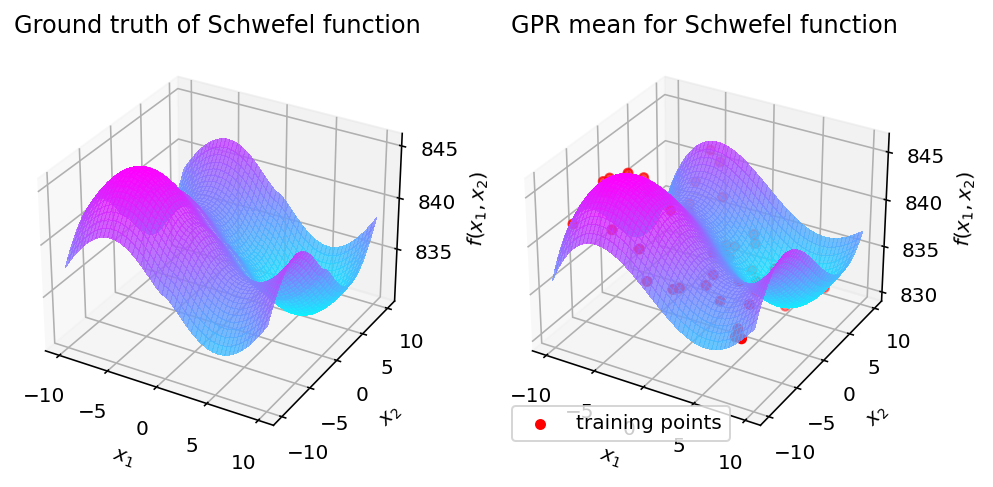

In [17]:
fig1 # show figure

We can also plot this information via contour plots, and show not only the mean predicted by GPR but also the standard deviation.

Note: you can also overlay the 95% confidence intervals in a surface plot, but usually it becomes really cluttered (so we didn't do it).

In [18]:
fig2 = plt.figure(figsize=plt.figaspect(0.5))
# Create Contour plot:
ax1 = fig2.add_subplot(1, 3, 1)
cset = ax1.contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title("Ground truth of %s function" % function_name)
fig2.colorbar(cset, ax=ax1)

# Create Contour plot:
ax2 = fig2.add_subplot(1, 3, 2)
cset = ax2.contourf(X1_grid, X2_grid, Y_grid_data_pred, cmap=set_cm)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title("GPR mean for %s function" % function_name)
fig2.colorbar(cset, ax=ax2)

# Create Contour plot:
ax3 = fig2.add_subplot(1, 3, 3)

SIGMA_grid_data_pred = np.reshape(sigma_data_pred,np.shape(X1_grid))

cset = ax3.contourf(X1_grid, X2_grid, SIGMA_grid_data_pred, cmap=set_cm)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.set_title("GPR STDV for %s function" % function_name)
fig2.colorbar(cset, ax=ax3)

plt.tight_layout()
plt.close(fig2) # close figure to open it in next cell.

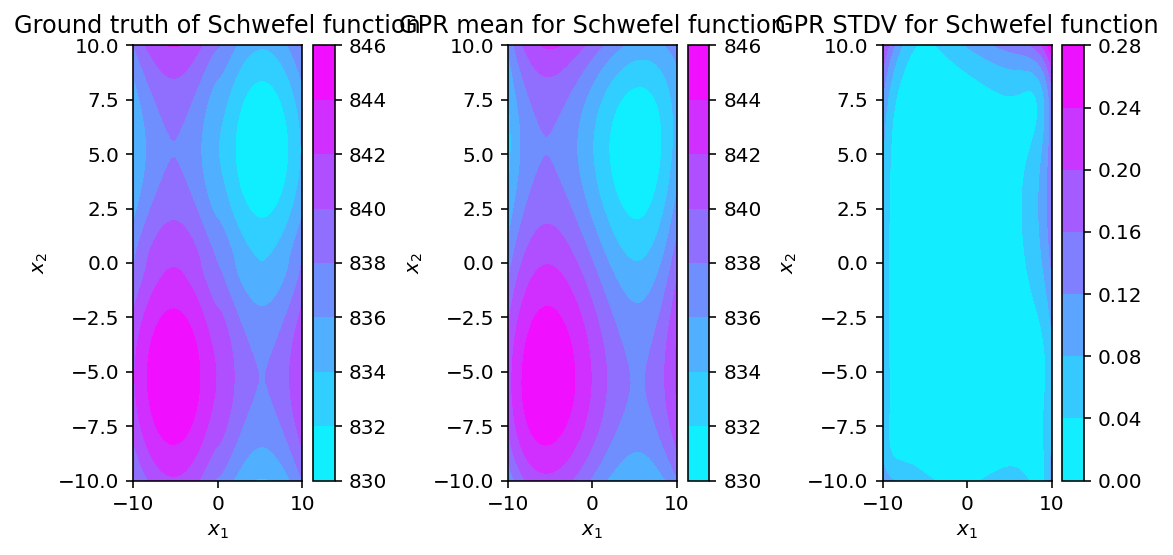

In [19]:
fig2 # show same results but using contour plots.

It's quite remarkable that GPR predicts this function almost perfectly while using only 50 points! This is equivalent to using just $\sqrt{50}\approx 7$ points per dimension!

Let's now compute the $R^2$ error metric for the GPR approximation.

In [20]:
from sklearn.metrics import r2_score # Import error metrics

# Compute MSE and R2 for the GP model
gp_r2_value = r2_score(y_test, y_test_pred)

print('R2 score for GPR = ', gp_r2_value)

R2 score for GPR =  0.993008284737578


However, **Gaussian Processes are not perfect!**

* Try to redo the GPR approximation but now using 75% of the data for training (click [here](##split_dataset) to go to cell where data was split)

* You will find that it will take a while to fit the GPR model (training dataset has 1875 points).

As we mentioned previously, Gaussian Processes are quite powerful but they are not very scalable.

## 1.2. Multidimensional regression with Artificial Neural Networks

As we discovered previously, ANNs behave in a somewhat opposite way: training for data scarce problems can be challenging, but ANNs are very scalable for "big data" problems.

Below is a code including an option to perform grid search (or not). The code is basically the same as what we saw in Lecture 10 but now with 2D features.

In [21]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
#
# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_ANN(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network?
# (slower)
gridsearch = 0

if gridsearch==1:
    # create model
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    # define the grid search parameters
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_ANN function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_ANN function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_ANN function)
    #
    batch_size = [len(X_train)]
    #
    epochs = [1000]
    #
    optimizer = ['adam']
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
    #
    param_grid = dict(batch_size=batch_size,
                      epochs=epochs,neurons1=neurons1,
                      neurons2=neurons2,
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer)
    NN_model = KerasRegressor(build_fn=create_ANN,
                              input_dimensions=np.shape(X_train)[1])
    grid = GridSearchCV(estimator=NN_model,
                        param_grid=param_grid,
                        n_jobs=1, cv=3, iid=False)
    grid_result = grid.fit(X_train_scaled, y_train,
                           callbacks=[early_stopping],
                           validation_data=(X_test_scaled, y_test_scaled))
    history = grid_result.best_estimator_.fit(X_train_scaled,
                                              y_train,
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_test_scaled))
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else: # just use a particular Neural Network of choice
    # Define early stopping:
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0.0,
                                   patience=30,
                                   mode='min')
    neurons1=200
    neurons2=10
    NN_model = KerasRegressor(build_fn=create_ANN,
                              input_dimensions=np.shape(X_train)[1],
                              neurons1=neurons1,
                              neurons2=neurons2,
                              batch_size=len(X_train),
                              epochs=1000,
                              optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(X_test_scaled,
                                               y_test_scaled))
    #
    history = NN_model.fit(X_train_scaled, y_train_scaled)

/tmp/ipykernel_126192/2473069601.py:75: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_ANN,
2022-03-14 13:36:31.194019: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 13:36:31.716828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37 MB memory:  -> device: 0, name: Quadro M2000, pci bus id: 0000:03:00.0, compute capability: 5.2


Epoch 1/1000
1/1 [==============================] - 1s 726ms/step - loss: 0.2761 - val_loss: 0.2615
Epoch 2/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2630 - val_loss: 0.2480
Epoch 3/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2504 - val_loss: 0.2359
Epoch 4/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.2388 - val_loss: 0.2259
Epoch 5/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.2293 - val_loss: 0.2175
Epoch 6/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.2209 - val_loss: 0.2099
Epoch 7/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.2133 - val_loss: 0.2031
Epoch 8/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.2064 - val_loss: 0.1972
Epoch 9/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.2002 - val_loss: 0.1921
Epoch 10/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.1945 - val_loss: 0.1876
Epoch 11

1/1 [==============================] - 0s 73ms/step - loss: 0.1195 - val_loss: 0.1461
Epoch 84/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.1191 - val_loss: 0.1457
Epoch 85/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.1187 - val_loss: 0.1452
Epoch 86/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.1183 - val_loss: 0.1448
Epoch 87/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.1179 - val_loss: 0.1444
Epoch 88/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.1175 - val_loss: 0.1440
Epoch 89/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.1171 - val_loss: 0.1436
Epoch 90/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.1167 - val_loss: 0.1432
Epoch 91/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.1163 - val_loss: 0.1427
Epoch 92/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.1159 - val_loss: 0.1423
Epoch 93/1000


1/1 [==============================] - 0s 78ms/step - loss: 0.0157 - val_loss: 0.0514
Epoch 165/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0154 - val_loss: 0.0505
Epoch 166/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0152 - val_loss: 0.0497
Epoch 167/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0149 - val_loss: 0.0491
Epoch 168/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.0147 - val_loss: 0.0486
Epoch 169/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0144 - val_loss: 0.0484
Epoch 170/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0142 - val_loss: 0.0482
Epoch 171/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0139 - val_loss: 0.0482
Epoch 172/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0137 - val_loss: 0.0482
Epoch 173/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0135 - val_loss: 0.0481
Epoch

1/1 [==============================] - 0s 82ms/step - loss: 0.0042 - val_loss: 0.0243
Epoch 246/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0041 - val_loss: 0.0242
Epoch 247/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0040 - val_loss: 0.0240
Epoch 248/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0040 - val_loss: 0.0238
Epoch 249/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0039 - val_loss: 0.0236
Epoch 250/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0039 - val_loss: 0.0234
Epoch 251/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0038 - val_loss: 0.0232
Epoch 252/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0038 - val_loss: 0.0230
Epoch 253/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0037 - val_loss: 0.0228
Epoch 254/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0037 - val_loss: 0.0227
Epoch

1/1 [==============================] - 0s 94ms/step - loss: 0.0018 - val_loss: 0.0147
Epoch 327/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.0018 - val_loss: 0.0145
Epoch 328/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0018 - val_loss: 0.0143
Epoch 329/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0017 - val_loss: 0.0141
Epoch 330/1000
1/1 [==============================] - 0s 88ms/step - loss: 0.0017 - val_loss: 0.0139
Epoch 331/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0017 - val_loss: 0.0137
Epoch 332/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0017 - val_loss: 0.0135
Epoch 333/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0016 - val_loss: 0.0134
Epoch 334/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0016 - val_loss: 0.0133
Epoch 335/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.0016 - val_loss: 0.0132
Epoch

Epoch 407/1000
1/1 [==============================] - 0s 75ms/step - loss: 9.3151e-04 - val_loss: 0.0100
Epoch 408/1000
1/1 [==============================] - 0s 77ms/step - loss: 9.2632e-04 - val_loss: 0.0099
Epoch 409/1000
1/1 [==============================] - 0s 78ms/step - loss: 9.2141e-04 - val_loss: 0.0099
Epoch 410/1000
1/1 [==============================] - 0s 80ms/step - loss: 9.1615e-04 - val_loss: 0.0099
Epoch 411/1000
1/1 [==============================] - 0s 77ms/step - loss: 9.1096e-04 - val_loss: 0.0099
Epoch 412/1000
1/1 [==============================] - 0s 76ms/step - loss: 9.0608e-04 - val_loss: 0.0099
Epoch 413/1000
1/1 [==============================] - 0s 75ms/step - loss: 9.0109e-04 - val_loss: 0.0098
Epoch 414/1000
1/1 [==============================] - 0s 73ms/step - loss: 8.9599e-04 - val_loss: 0.0098
Epoch 415/1000
1/1 [==============================] - 0s 76ms/step - loss: 8.9128e-04 - val_loss: 0.0098
Epoch 416/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 70ms/step - loss: 6.2257e-04 - val_loss: 0.0085
Epoch 486/1000
1/1 [==============================] - 0s 76ms/step - loss: 6.1958e-04 - val_loss: 0.0085
Epoch 487/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.1659e-04 - val_loss: 0.0085
Epoch 488/1000
1/1 [==============================] - 0s 74ms/step - loss: 6.1361e-04 - val_loss: 0.0085
Epoch 489/1000
1/1 [==============================] - 0s 70ms/step - loss: 6.1063e-04 - val_loss: 0.0085
Epoch 490/1000
1/1 [==============================] - 0s 76ms/step - loss: 6.0767e-04 - val_loss: 0.0085
Epoch 491/1000
1/1 [==============================] - 0s 80ms/step - loss: 6.0473e-04 - val_loss: 0.0085
Epoch 492/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.0178e-04 - val_loss: 0.0084
Epoch 493/1000
1/1 [==============================] - 0s 78ms/step - loss: 5.9885e-04 - val_loss: 0.0084
Epoch 494/1000
1/1 [==============================] - 0s 77ms/step - l

1/1 [==============================] - 0s 74ms/step - loss: 4.2374e-04 - val_loss: 0.0077
Epoch 564/1000
1/1 [==============================] - 0s 73ms/step - loss: 4.2154e-04 - val_loss: 0.0077
Epoch 565/1000
1/1 [==============================] - 0s 69ms/step - loss: 4.1950e-04 - val_loss: 0.0077
Epoch 566/1000
1/1 [==============================] - 0s 70ms/step - loss: 4.1724e-04 - val_loss: 0.0077
Epoch 567/1000
1/1 [==============================] - 0s 75ms/step - loss: 4.1515e-04 - val_loss: 0.0077
Epoch 568/1000
1/1 [==============================] - 0s 82ms/step - loss: 4.1313e-04 - val_loss: 0.0077
Epoch 569/1000
1/1 [==============================] - 0s 82ms/step - loss: 4.1100e-04 - val_loss: 0.0077
Epoch 570/1000
1/1 [==============================] - 0s 74ms/step - loss: 4.0899e-04 - val_loss: 0.0077
Epoch 571/1000
1/1 [==============================] - 0s 79ms/step - loss: 4.0691e-04 - val_loss: 0.0077
Epoch 572/1000
1/1 [==============================] - 0s 76ms/step - l

1/1 [==============================] - 0s 77ms/step - loss: 2.5940e-04 - val_loss: 0.0071
Epoch 642/1000
1/1 [==============================] - 0s 70ms/step - loss: 2.5765e-04 - val_loss: 0.0071
Epoch 643/1000
1/1 [==============================] - 0s 80ms/step - loss: 2.5595e-04 - val_loss: 0.0071
Epoch 644/1000
1/1 [==============================] - 0s 75ms/step - loss: 2.5428e-04 - val_loss: 0.0071
Epoch 645/1000
1/1 [==============================] - 0s 73ms/step - loss: 2.5262e-04 - val_loss: 0.0071
Epoch 646/1000
1/1 [==============================] - 0s 74ms/step - loss: 2.5096e-04 - val_loss: 0.0071
Epoch 647/1000
1/1 [==============================] - 0s 76ms/step - loss: 2.4980e-04 - val_loss: 0.0070
Epoch 648/1000
1/1 [==============================] - 0s 75ms/step - loss: 2.4841e-04 - val_loss: 0.0070
Epoch 649/1000
1/1 [==============================] - 0s 73ms/step - loss: 2.4674e-04 - val_loss: 0.0070
Epoch 650/1000
1/1 [==============================] - 0s 76ms/step - l

1/1 [==============================] - 0s 72ms/step - loss: 1.6210e-04 - val_loss: 0.0066
Epoch 720/1000
1/1 [==============================] - 0s 76ms/step - loss: 1.6112e-04 - val_loss: 0.0066
Epoch 721/1000
1/1 [==============================] - 0s 80ms/step - loss: 1.6020e-04 - val_loss: 0.0066
Epoch 722/1000
1/1 [==============================] - 0s 73ms/step - loss: 1.5921e-04 - val_loss: 0.0066
Epoch 723/1000
1/1 [==============================] - 0s 83ms/step - loss: 1.5827e-04 - val_loss: 0.0066
Epoch 724/1000
1/1 [==============================] - 0s 75ms/step - loss: 1.5733e-04 - val_loss: 0.0066
Epoch 725/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.5639e-04 - val_loss: 0.0066
Epoch 726/1000
1/1 [==============================] - 0s 80ms/step - loss: 1.5548e-04 - val_loss: 0.0066
Epoch 727/1000
1/1 [==============================] - 0s 77ms/step - loss: 1.5456e-04 - val_loss: 0.0066
Epoch 728/1000
1/1 [==============================] - 0s 75ms/step - l

1/1 [==============================] - 0s 74ms/step - loss: 1.0182e-04 - val_loss: 0.0064
Epoch 798/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.0121e-04 - val_loss: 0.0064
Epoch 799/1000
1/1 [==============================] - 0s 71ms/step - loss: 1.0061e-04 - val_loss: 0.0064
Epoch 800/1000
1/1 [==============================] - 0s 75ms/step - loss: 1.0003e-04 - val_loss: 0.0063
Epoch 801/1000
1/1 [==============================] - 0s 71ms/step - loss: 9.9382e-05 - val_loss: 0.0063
Epoch 802/1000
1/1 [==============================] - 0s 71ms/step - loss: 9.8779e-05 - val_loss: 0.0063
Epoch 803/1000
1/1 [==============================] - 0s 68ms/step - loss: 9.8153e-05 - val_loss: 0.0063
Epoch 804/1000
1/1 [==============================] - 0s 79ms/step - loss: 9.7541e-05 - val_loss: 0.0063
Epoch 805/1000
1/1 [==============================] - 0s 71ms/step - loss: 9.6957e-05 - val_loss: 0.0063
Epoch 806/1000
1/1 [==============================] - 0s 86ms/step - l

1/1 [==============================] - 0s 79ms/step - loss: 6.3217e-05 - val_loss: 0.0062
Epoch 876/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.2857e-05 - val_loss: 0.0062
Epoch 877/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.2513e-05 - val_loss: 0.0062
Epoch 878/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.2176e-05 - val_loss: 0.0062
Epoch 879/1000
1/1 [==============================] - 0s 72ms/step - loss: 6.1831e-05 - val_loss: 0.0062
Epoch 880/1000
1/1 [==============================] - 0s 72ms/step - loss: 6.1511e-05 - val_loss: 0.0062
Epoch 881/1000
1/1 [==============================] - 0s 74ms/step - loss: 6.1178e-05 - val_loss: 0.0061
Epoch 882/1000
1/1 [==============================] - 0s 73ms/step - loss: 6.0835e-05 - val_loss: 0.0061
Epoch 883/1000
1/1 [==============================] - 0s 83ms/step - loss: 6.0514e-05 - val_loss: 0.0061
Epoch 884/1000
1/1 [==============================] - 0s 78ms/step - l

1/1 [==============================] - 0s 75ms/step - loss: 4.0144e-05 - val_loss: 0.0060
Epoch 954/1000
1/1 [==============================] - 0s 73ms/step - loss: 3.9935e-05 - val_loss: 0.0060
Epoch 955/1000
1/1 [==============================] - 0s 75ms/step - loss: 3.9726e-05 - val_loss: 0.0060
Epoch 956/1000
1/1 [==============================] - 0s 75ms/step - loss: 3.9523e-05 - val_loss: 0.0060
Epoch 957/1000
1/1 [==============================] - 0s 74ms/step - loss: 3.9320e-05 - val_loss: 0.0060
Epoch 958/1000
1/1 [==============================] - 0s 76ms/step - loss: 3.9117e-05 - val_loss: 0.0060
Epoch 959/1000
1/1 [==============================] - 0s 76ms/step - loss: 3.8924e-05 - val_loss: 0.0060
Epoch 960/1000
1/1 [==============================] - 0s 76ms/step - loss: 3.8727e-05 - val_loss: 0.0060
Epoch 961/1000
1/1 [==============================] - 0s 75ms/step - loss: 3.8534e-05 - val_loss: 0.0060
Epoch 962/1000
1/1 [==============================] - 0s 72ms/step - l

Let's plot the result for ANN as we did for GPR.

In [22]:
fig3 = plt.figure(figsize=plt.figaspect(0.5))
#
# Subplot 1 (left): ground truth
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1_grid, X2_grid, Y_grid, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
# Create axis labels and title:
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x_1,x_2)$')
ax1.set_title("Ground truth of %s function" % function_name)

# Subplot 2 (right): ANN prediction 
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
y_data_pred_scaled = history.model.predict(X_data_scaled)
y_data_pred = scaler_y.inverse_transform(y_data_pred_scaled) # scale predictions back to original scale

Y_grid_data_pred = np.reshape(y_data_pred, np.shape(X1_grid)) # putting targets in grid format for plotting

surf = ax2.plot_surface(X1_grid, X2_grid, Y_grid_data_pred, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
# Create axis labels and title:
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$f(x_1,x_2)$')
ax2.set_title("ANN approximation of %s function" % function_name)
ax2.scatter(X_train[:,0], X_train[:,1], y_train,
            marker='o', color='red',
           label="training points")
ax2.legend(loc='lower left')

plt.tight_layout()
plt.close(fig3)

In [23]:
fig3 # surface plots for ANN

<Figure size 576x288 with 0 Axes>

The approximation does not seem too bad (and it can get a lot better!).

* However, it can be challenging to make ANNs as good as GPR for a small number of training points (and there is a theoretical result that explains why!).

Finally, let's calculate the R2 score for the ANN.

In [24]:
# Compute R2 for the ANN model

y_test_pred_scaled = history.model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred) # scale predictions back to original scale

ANN_r2_value = r2_score(y_test, y_test_pred)

print('R2 score for ANN = ', ANN_r2_value)

R2 score for ANN =  -2761042.452664363


Try training GPR and ANN using different split ratio for training and testing data!

* Click [here](##split_dataset) to go to the cell where data was split.

## 1.3. GPR and ANN with noisy datasets

Due to time constraints, I won't do with you the same cases when considering a noisy dataset...

But I am including the codes here and we can take a look at the results.

In [25]:
# Create the noisy dataset:
random_std = 0.05+0.1*np.random.random(y_data.shape)
max_diff = np.max(y_data)-np.min(y_data) # magnitude of signal
noise_data = np.random.normal(0,random_std)*max_diff
y_noisy_data = y_data + noise_data # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise_data))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?

y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler().fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)

# Scaling outputs with a Standard Scaler:
y_noisy_train = y_noisy_train.reshape(-1, 1)
y_noisy_test = y_noisy_test.reshape(-1, 1)
y_noisy_data = y_noisy_data.reshape(-1, 1)
#
scaler_y = MinMaxScaler().fit(y_noisy_train)
#
y_noisy_train_scaled=scaler_y.transform(y_noisy_train)
y_noisy_test_scaled=scaler_y.transform(y_noisy_test)
y_noisy_data_scaled=scaler_y.transform(y_noisy_data)

In [26]:
# GPR
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel,
                                    alpha=noise_train.ravel()**2,
                                    n_restarts_optimizer=20) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_noisy_train)

# Make the prediction on the entire dataset (for plotting)
y_noisy_data_pred, sigma_noisy_data_pred = gp_model.predict(X_data,
                                                            return_std=True) # also output the uncertainty (standard deviation)

# Predict for test set (for error metric)
y_noisy_test_pred, sigma_noisy_test_pred = gp_model.predict(X_test,
                                                            return_std=True) # also output the uncertainty (standard deviation)

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [27]:
# PLOTS
# Figure 1
# Subplot 1
fig1 = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1_grid, X2_grid, Y_grid,
                       cmap=set_cm, alpha=0.8,
                       linewidth=0, antialiased=False)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x_1,x_2)$')
ax1.set_title("Ground truth of %s function" % function_name)
ax1.scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
           label="training points")
ax1.legend(loc='lower left')

# Subplot 2
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
Y_grid_noisy_data_pred = np.reshape(y_noisy_data_pred,np.shape(X1_grid))
surf = ax2.plot_surface(X1_grid, X2_grid,
                        Y_grid_noisy_data_pred,
                        cmap=set_cm, alpha=0.8,
                        linewidth=0, antialiased=False)
# Create axis labels and title:
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$f(x_1,x_2)$')
ax2.set_title("GPR mean for %s function" % function_name)
ax2.scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
           label="training points")
ax2.legend(loc='lower left')

plt.tight_layout()
plt.close(fig1)

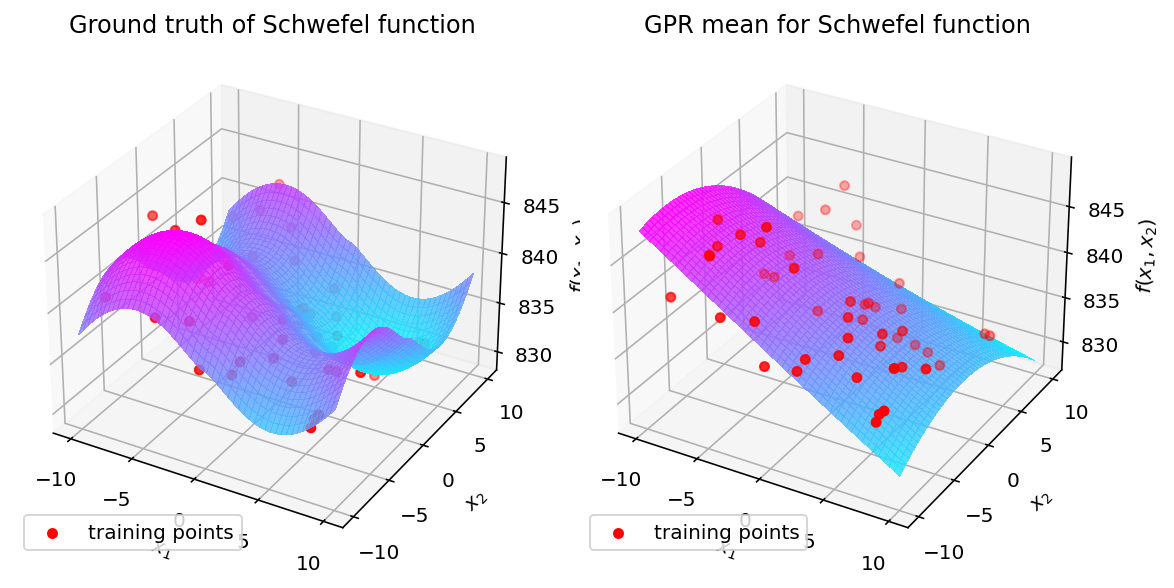

In [28]:
fig1 # plot surfaces

In [29]:
#---------------------------------------------------------
# Figure 2
fig2 = plt.figure(figsize=plt.figaspect(0.5))
# Create Contour plot:
ax3 = fig2.add_subplot(1, 3, 1)
cset = ax3.contourf(X1_grid, X1_grid, Y_grid, cmap=set_cm)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.set_title("Ground truth of %s function" % function_name)
fig2.colorbar(cset, ax=ax3)

# Create Contour plot:
ax4 = fig2.add_subplot(1, 3, 2)
cset = ax4.contourf(X1_grid, X2_grid,
                    Y_grid_noisy_data_pred,
                    cmap=set_cm)
ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$x_2$')
ax4.set_title("GPR mean for %s function" % function_name)
fig2.colorbar(cset, ax=ax4)

# Create Contour plot:
ax5 = fig2.add_subplot(1, 3, 3)
SIGMA_grid_noisy_data_pred = np.reshape(sigma_noisy_data_pred,
                                        np.shape(X1_grid))
cset = ax5.contourf(X1_grid, X2_grid,
                    SIGMA_grid_noisy_data_pred,
                    cmap=set_cm)
ax5.set_xlabel('$x_1$')
ax5.set_ylabel('$x_2$')
ax5.set_title("GPR STDV for %s function" % function_name)
fig2.colorbar(cset, ax=ax5)

plt.tight_layout()
plt.close(fig2)

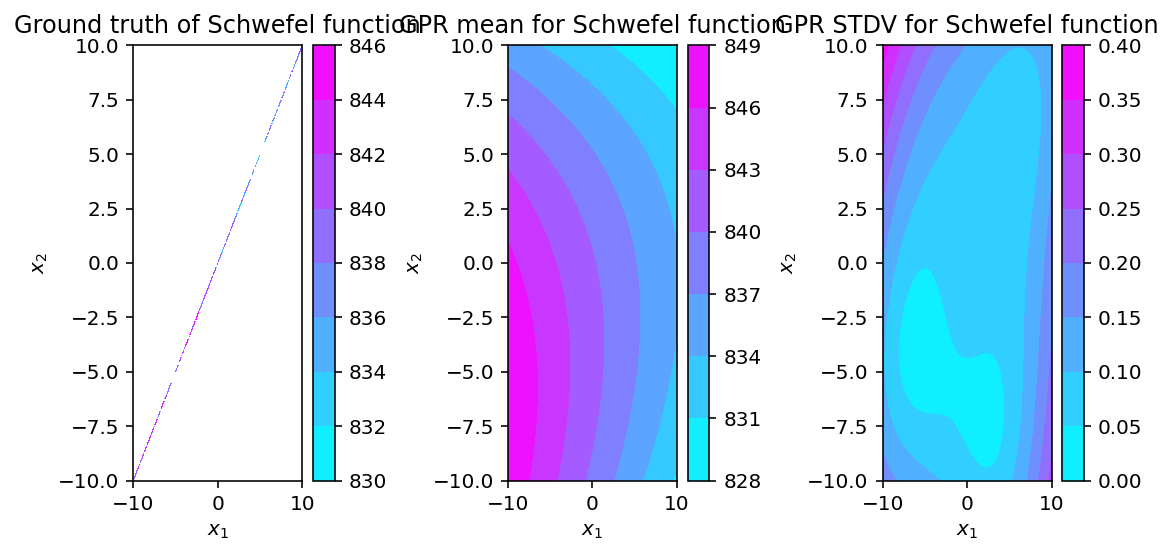

In [30]:
fig2 # plot contours

In [31]:
# Error metric
# Compute R2 for the GP model
gp_r2_value = r2_score(y_noisy_test, y_noisy_test_pred)

print('R2 score for GPR = ', gp_r2_value)

R2 score for GPR =  0.15746176119810718


In [32]:
# And now for the ANN:

# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
#
# Do you want to look for the best parameters for the Neural Network?
# (slower)
gridsearch = 0

if gridsearch==1:
    # create model
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
#    NN_model = KerasRegressor(build_fn=create_model(input_dimensions=1,neurons=20),
#                              callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    # define the grid search parameters
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_model function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_model function)
    #
    batch_size = [len(X_train)]
    #
    epochs = [1000]
    #
    optimizer = ['adam']
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
    #
    param_grid = dict(batch_size=batch_size,
                      epochs=epochs,neurons1=neurons1,
                      neurons2=neurons2,
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer)
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1])
    grid = GridSearchCV(estimator=NN_model,
                        param_grid=param_grid,
                        n_jobs=1, cv=3, iid=False)
    grid_result = grid.fit(X_train_scaled, y_train,
                           callbacks=[early_stopping],
                           validation_data=(X_test_scaled, y_noisy_test_scaled))
    history = grid_result.best_estimator_.fit(X_train_scaled,
                                              y_train,
                                              callbacks=[early_stopping],
                                              validation_data=(X_test_scaled,
                                                               y_noisy_test_scaled))
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else: # just use a particular Neural Network of choice
    # Define early stopping:
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0.0,
                                   patience=30,
                                   mode='min')
    neurons1=200
    neurons2=10
    NN_model = KerasRegressor(build_fn=create_model,
                              input_dimensions=np.shape(X_train)[1],
                              neurons1=neurons1,
                              neurons2=neurons2,
                              batch_size=len(X_train),
                              epochs=1000,
                              optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(X_test_scaled,
                                               y_noisy_test_scaled))
    #
    history = NN_model.fit(X_train_scaled, y_noisy_train_scaled)
#    

Epoch 1/1000


/tmp/ipykernel_126192/1324377696.py:72: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_model,


1/1 [==============================] - 0s 340ms/step - loss: 0.2503 - val_loss: 0.2405
Epoch 2/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.2247 - val_loss: 0.2185
Epoch 3/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.2039 - val_loss: 0.2017
Epoch 4/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.1871 - val_loss: 0.1910
Epoch 5/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.1763 - val_loss: 0.1820
Epoch 6/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.1674 - val_loss: 0.1738
Epoch 7/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.1598 - val_loss: 0.1661
Epoch 8/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.1530 - val_loss: 0.1584
Epoch 9/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.1466 - val_loss: 0.1503
Epoch 10/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.1400 - val_loss: 0.1415
Epoch 11/1000
1/1 [==

1/1 [==============================] - 0s 76ms/step - loss: 0.0155 - val_loss: 0.0282
Epoch 84/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0154 - val_loss: 0.0282
Epoch 85/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0153 - val_loss: 0.0281
Epoch 86/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0152 - val_loss: 0.0280
Epoch 87/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0151 - val_loss: 0.0279
Epoch 88/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0150 - val_loss: 0.0278
Epoch 89/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0148 - val_loss: 0.0277
Epoch 90/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0147 - val_loss: 0.0276
Epoch 91/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0146 - val_loss: 0.0274
Epoch 92/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0145 - val_loss: 0.0273
Epoch 93/1000


1/1 [==============================] - 0s 78ms/step - loss: 0.0086 - val_loss: 0.0208
Epoch 165/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0085 - val_loss: 0.0207
Epoch 166/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.0084 - val_loss: 0.0206
Epoch 167/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0083 - val_loss: 0.0205
Epoch 168/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0082 - val_loss: 0.0204
Epoch 169/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0081 - val_loss: 0.0202
Epoch 170/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0080 - val_loss: 0.0201
Epoch 171/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0079 - val_loss: 0.0200
Epoch 172/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0078 - val_loss: 0.0199
Epoch 173/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0077 - val_loss: 0.0198
Epoch

1/1 [==============================] - 0s 75ms/step - loss: 0.0038 - val_loss: 0.0161
Epoch 246/1000
1/1 [==============================] - 0s 82ms/step - loss: 0.0038 - val_loss: 0.0161
Epoch 247/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.0038 - val_loss: 0.0161
Epoch 248/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0037 - val_loss: 0.0160
Epoch 249/1000
1/1 [==============================] - 0s 75ms/step - loss: 0.0037 - val_loss: 0.0160
Epoch 250/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0037 - val_loss: 0.0160
Epoch 251/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0037 - val_loss: 0.0160
Epoch 252/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0036 - val_loss: 0.0160
Epoch 253/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0036 - val_loss: 0.0160
Epoch 254/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.0036 - val_loss: 0.0160
Epoch

1/1 [==============================] - 0s 71ms/step - loss: 0.0024 - val_loss: 0.0159
Epoch 327/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0024 - val_loss: 0.0159


In [33]:
# PLOTS
# Figure 1 is a Surface plot of the ground truth and
# the ANN approximation (2 subplots):
fig1 = plt.figure(figsize=plt.figaspect(0.5))
#
# Subplot 1 (top) of Figure 1: ground truth
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
#
# Don't forget that for a Surface plot we need the data
# coming out of meshgrid not in the format of X_data (!)
#
surf = ax1.plot_surface(X1_grid, X2_grid, Y_grid,
                       cmap=set_cm, alpha=0.8,
                       linewidth=0, antialiased=False)
#
# Create axis labels and title:
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x_1,x_2)$')
ax1.set_title("Ground truth of %s function" % function_name)
ax1.scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
            label="training points")
ax1.legend(loc='lower left')

# Subplot 2 (bottom) of Figure 1
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
#
y_noisy_data_pred_scaled = history.model.predict(X_data_scaled)
y_noisy_data_pred = scaler_y.inverse_transform(y_noisy_data_pred_scaled) # scaling targets back
Y_grid_noisy_data_pred = np.reshape(y_noisy_data_pred, np.shape(X1_grid))

surf = ax2.plot_surface(X1_grid, X2_grid, Y_grid_noisy_data_pred,
                       cmap=set_cm, alpha=0.8,linewidth=0, antialiased=False)
# Create axis labels and title:
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$f(x_1,x_2)$')
ax2.set_title("ANN approximation of %s function" % function_name)
ax2.scatter(X_train[:,0], X_train[:,1], y_noisy_train,
            marker='o', color='red',
           label="training points")
ax2.legend(loc='lower left')

plt.tight_layout()
plt.close(fig1)

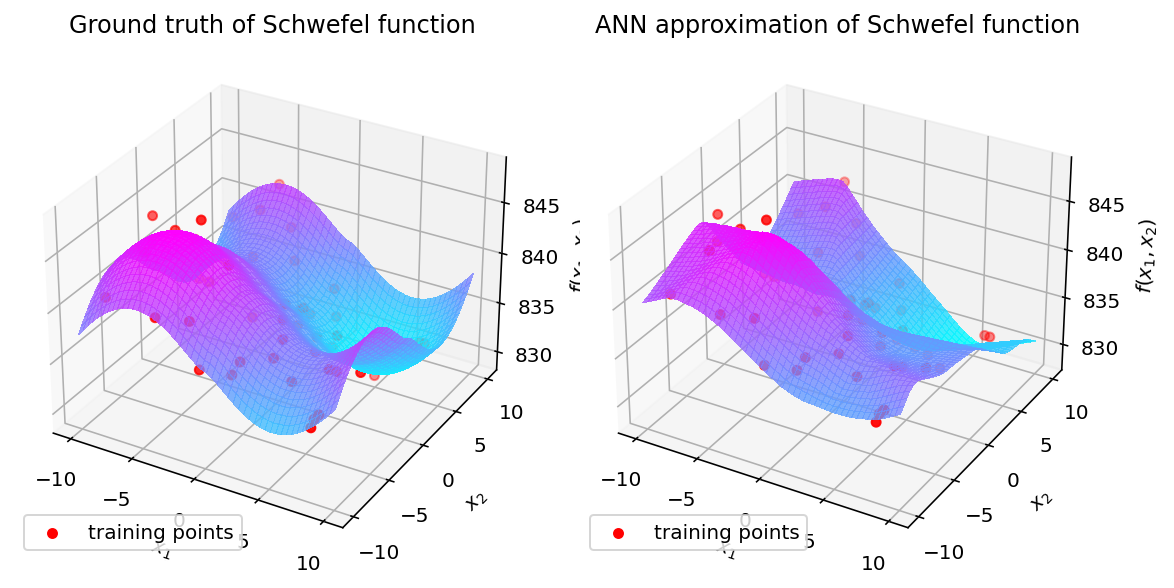

In [34]:
fig1 # plot surfaces for ANN

In [35]:
# Compute R2 for the ANN model
y_noisy_test_pred = history.model.predict(X_test_scaled)
ANN_r2_value = r2_score(y_noisy_test, scaler_y.inverse_transform(y_noisy_test_pred))
# note the transformation of the outputs back to the original scale

print('R2 score for ANN = ', ANN_r2_value)

R2 score for ANN =  0.6863829936384857


## Don't forget to "play" with this notebook

* **Try learning different functions**: go to the beginning of the notebook and change the benchmark function to be learned (e.g. Levy function)
* Use different noise levels
* Try different kernels for the GPR
* Do a Grid Search to find better parameters for the ANN
* Investigate the role of "early stopping" in the ANN

There are so many things that you can do to go deeper in the topic! Have some fun with it!

**Important Note:** Despite this notebook being dedicated to 3D surfaces (2 features and 1 target), the algorithms are general. In principle, they can perform regression for any dimensionality of features and targets (although for GPR if you want more than one output you have to consider modifications to the method). The codes do not change significantly, but visualizing data can be a challenge. The simplest solution is to project the space back to a 3D space. You will do that in your projects.

# 2. Multidimensional classification

Here's some good news:

* If you understand regression with supervised learning... Then, performing classification with supervised learning is very similar!

But first: what is classification?

* Classification problems occur when the target (output) is **discrete**, instead of being a continuous variable like we did in regression problems.

* A simple classification problem that is very common to consider when first learning about this topic is the [Iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris) created by UCI researchers in 1936.

* I downloaded the .CSV file from [Kaggle](https://www.kaggle.com/) and it is included in the docs folder of this GitHub repository.

Therefore, we can load that .CSV file into a Pandas DataFrame!

In [36]:
# Load the Iris dataset.
iris_data = pd.read_csv('docs/Iris.csv')

print(iris_data)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

#### A short note

In fact, the Iris dataset is **so common**, that scikit-learn already has it saved and it can be loaded directly from the scikit-learn code, as shown below.

In [37]:
# In case you wanted to load the Iris dataset directly from scikit-learn.
from sklearn.datasets import load_iris

iris = load_iris() # load Iris dataset that already exists in Scikit-learn
# Convert it to a Pandas Dataframe
data1 = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# You can print(data1) and see that it is the same dataset.

# But I think it is informative to understand the usual process
# in machine learning: someone gives us a dataset (or we download
# it from somewhere) and we usually load it with Pandas due to its
# versatility.

When you start a new problem, the first step is:

* Get to know the dataset.

What are the features? And the targets? What kind of data preprocessing should we do? What do we know *before* using machine learning tools to analyze the dataset?

<img src="docs/iris_dataset_explanation.png" title="Flower to explain Iris dataset" width="25%" align="right">

Here's a nice image to understand the dataset.

The dataset is quite simple! It has:

* 4 Features (inputs): sepal length, sepal width, petal length, petal width


* 1 Target (output): iris species (3 different species with 50 samples each)

So, the dataset has 150 samples of 3 different species of iris flower (50 samples per species) and each flower has 4 features that characterize it: the length and width of the petal and the sepal (see figure on the right).

**Our task**: Learn from part of the dataset how to classify a new iris flower into one of the 3 species!

Note: This example is straight out of Scikit-learn (but simplified)

In [38]:
# Let's only use the first two features (ignoring the other 2).
X_2d = iris_data.loc[:, ['SepalLengthCm','SepalWidthCm'] ].values # just use 2 inputs (features)
y_string = iris_data.loc[:, 'Species'].values

print('y_string = ',y_string,'\n\n')

y_string =  ['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iri

It's also very common to convert our target (output) data from strings to integers!

In this case we have three discrete target values ('Iris-setosa', 'Iris-versicolor' and 'Iris-virginica') so we can convert to 0, 1 and 2

In [39]:
# Pandas makes this very easy for us. Just one line!
y = pd.Categorical(pd.factorize(y_string)[0])

print('y = ',y)

y =  [0, 0, 0, 0, 0, ..., 2, 2, 2, 2, 2]
Length: 150
Categories (3, int64): [0, 1, 2]


Let's consider one of the simplest supervised learning classification algorithms: **Support Vector Machines**.

Note: we can also do classification with Gaussian Processes and with Artificial Neural Networks. But I just want to show a few other examples of algorithms because you will need to search for algorithms you don't know, understand them and decide if they are applicable or not to your problem of interest.

In [40]:
from sklearn import svm
# we create an instance of SVM and fit out data. We do not scale our
# data (this dataset is quite simple)
C = 1.0  # SVM regularization parameter
svm_model = svm.SVC(kernel='rbf', gamma=0.7, C=C)

svm_model.fit(X_2d, y)

SVC(gamma=0.7)

In [41]:
# Set-up 2x2 grid for plotting.
fig, ax = plt.subplots()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X1, X2 = X_2d[:, 0], X_2d[:, 1]

X1_min, X1_max = X1.min() - 1, X1.max() + 1 # define min and max of feature 0
X2_min, X2_max = X2.min() - 1, X2.max() + 1 # define min and max of feature 1
X1_grid, X2_grid = np.meshgrid(np.arange(X1_min, X1_max, 0.02),
                               np.arange(X2_min, X2_max, 0.02))

y_pred = svm_model.predict(np.c_[X1_grid.ravel(), X2_grid.ravel()])
Y_grid = y_pred.reshape(X1_grid.shape)

ax.contourf(X1_grid, X2_grid, Y_grid, cmap=cm.coolwarm, alpha=0.8)

ax.scatter(X1, X2, c=y, cmap=cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(X1_grid.min(), X1_grid.max())
ax.set_ylim(X2_grid.min(), X2_grid.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('SVC with RBF kernel')

plt.close(fig)

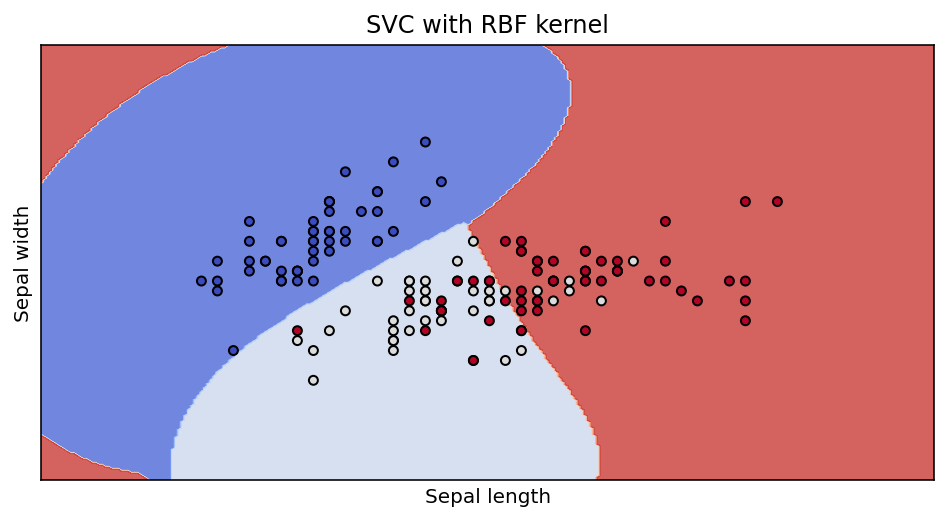

In [42]:
fig # classification plot using only 2 features ('SepalLengthCm' and 'SepalWidthCm')

Let's now plot for all 4 features, instead of considering only the first 2.

Let's also use a different classifier. Instead of Support Vector Machines (SVM), we will use **Decision Trees**.

The following is also an example from Scikit-learn.

In [43]:
# Load all the features and the target variables:
X = iris_data.iloc[:, 1:5 ].values # now using all 4 features (inputs)
feature_names = iris_data.columns.values[1:5] # not including the "ID" column

y_strings = iris_data.loc[:, 'Species'].values
target_names = iris_data.loc[:, 'Species'].unique()

print(feature_names)
print(target_names)

['SepalLengthCm' 'SepalWidthCm' 'PetalLengthCm' 'PetalWidthCm']
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [45]:
from sklearn.tree import DecisionTreeClassifier
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

fig, ax = plt.subplots() # open figure
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    #X_temp = iris.data[:, pair]
    #y_temp = iris.target

    X_temp = X[:, pair]
    
    # Train
    clf = DecisionTreeClassifier().fit(X_temp, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x1_min, x1_max = X_temp[:, 0].min() - 1, X_temp[:, 0].max() + 1
    x2_min, x2_max = X_temp[:, 1].min() - 1, X_temp[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, plot_step),
                         np.arange(x2_min, x2_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Y = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=cm.RdYlBu)

    plt.xlabel(feature_names[pair[0]])
    plt.ylabel(feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X_temp[idx, 0], X_temp[idx, 1], c=color,
                    label=target_names[i],cmap=plt.cm.RdYlBu,
                    edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.close(fig)

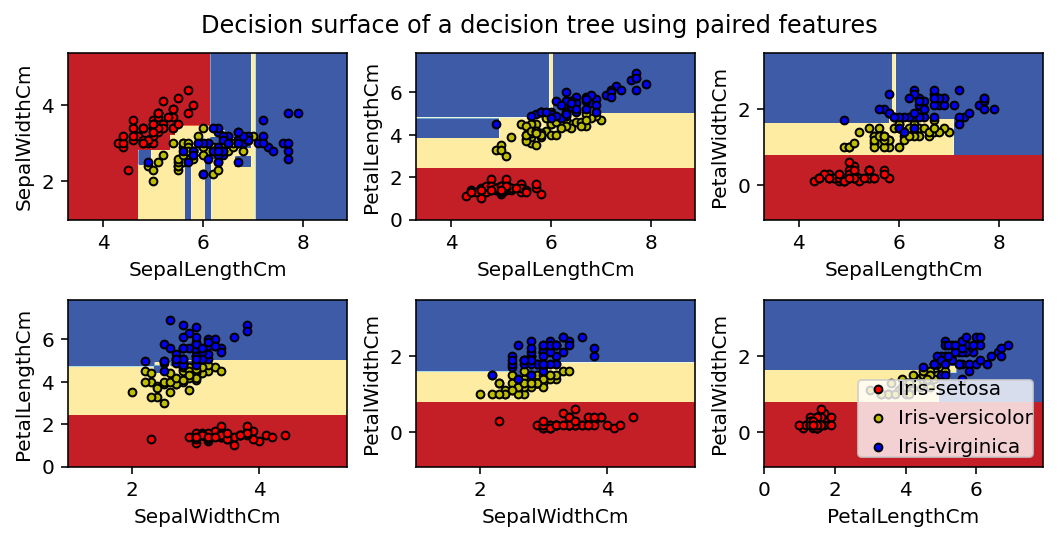

In [46]:
fig # classification plot with Decision Trees for all 4 features (showing them in pairs of 2)

### You will explore these and other things in Part 3 of the Midterm Project...

Have fun!